
### Experiment 6: Training Schedule ##
**Initial Base-Line Run: (With imbalanced data of 159 (Apples), 140 (Oranges), 200 Bananas (Mixed), and 200 (Mixed) images)** 


In [32]:
# Core
import os
import random
from collections import Counter, defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Visualization and Evaluation
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report


In [33]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define transforms for the training dataset
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Load the training dataset from the correct path
train_data = ImageFolder(root='./train', transform=transform)

# Confirm dataset is loaded
print(f"Loaded {len(train_data)} training images from {train_data.root}")
print("Class-to-index mapping:", train_data.class_to_idx)


Loaded 650 training images from ./train
Class-to-index mapping: {'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}


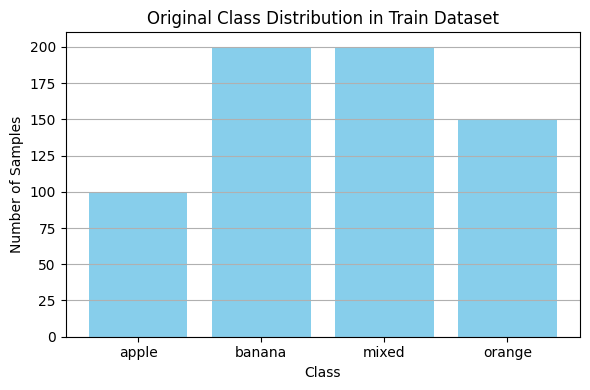

In [41]:
from collections import Counter
import matplotlib.pyplot as plt

# Count how many samples there are per class
targets = train_data.targets  # List of labels for each image
class_counts = Counter(targets)

# Map indices to class names
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}
class_names = [idx_to_class[i] for i in class_counts.keys()]
class_values = [class_counts[i] for i in class_counts.keys()]

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(class_names, class_values, color='skyblue')
plt.title("Original Class Distribution in Train Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


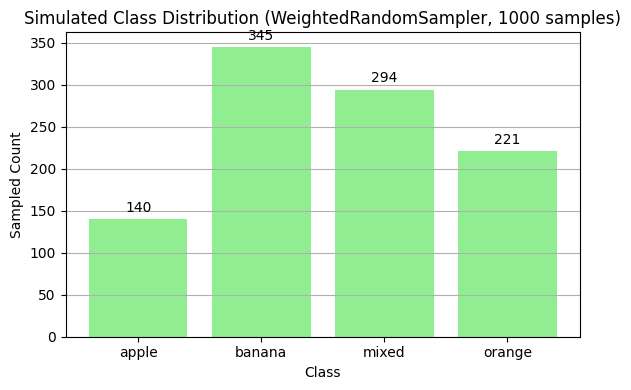

In [53]:
from torch.utils.data import WeightedRandomSampler
import random
import matplotlib.pyplot as plt
from collections import Counter

# Create mapping from class index to class name (if not already defined)
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}

# Simulate 1000 samples using the WeightedRandomSampler
simulated_sampler = WeightedRandomSampler(train_sample_weights, num_samples=1000, replacement=True)
sampled_indices = list(simulated_sampler)

# Map back to original labels using subset indices
subset_indices = train_dataset.indices  # Maps back to original train_data
sampled_labels = [train_data.targets[subset_indices[i]] for i in sampled_indices]

# Count sampled labels
sampled_counts = Counter(sampled_labels)

# Ensure all class indices show up
all_class_indices = sorted(idx_to_class.keys())
sampled_counts_complete = {i: sampled_counts.get(i, 0) for i in all_class_indices}

# Prepare data for plotting
sampled_class_names = [idx_to_class[i] for i in all_class_indices]
sampled_values = [sampled_counts_complete[i] for i in all_class_indices]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(sampled_class_names, sampled_values, color='lightgreen')
plt.title("Simulated Class Distribution (WeightedRandomSampler, 1000 samples)")
plt.xlabel("Class")
plt.ylabel("Sampled Count")
plt.grid(axis='y')

# Add counts on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [38]:
from collections import Counter, defaultdict
from torch.utils.data import WeightedRandomSampler, Subset, random_split
import random

# Count class distribution from full dataset
targets = train_data.targets
class_counts = Counter(targets)

# Compute class weights (inverse of frequency)
num_samples = len(train_data)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}

# Assign a weight to each sample
sample_weights = [class_weights[label] for label in targets]

# Build class_indices from ENTIRE dataset (not just 70%)
class_indices = defaultdict(list)
for idx, label in enumerate(train_data.targets):
    class_indices[label].append(idx)

# Define exact sample counts
desired_counts = {
    'apple': 100,
    'banana': 200,
    'mixed': 200,
    'orange': 150
}

# Collect indices based on desired counts
final_indices = []
for cls_name, count in desired_counts.items():
    cls_idx = train_data.class_to_idx[cls_name]
    available = len(class_indices[cls_idx])
    if count > available:
        raise ValueError(f"Requested {count} samples for class '{cls_name}', but only {available} available.")
    final_indices.extend(random.sample(class_indices[cls_idx], count))

# Split selected data into train/val (70/30)
train_size = int(0.7 * len(final_indices))
val_size = len(final_indices) - train_size
train_indices, val_indices = random_split(
    final_indices, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Create datasets
train_dataset = Subset(train_data, train_indices)
val_dataset = Subset(train_data, val_indices)

# Create Weighted Sampler for training
train_sample_weights = [sample_weights[i] for i in train_indices]
train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_indices), replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


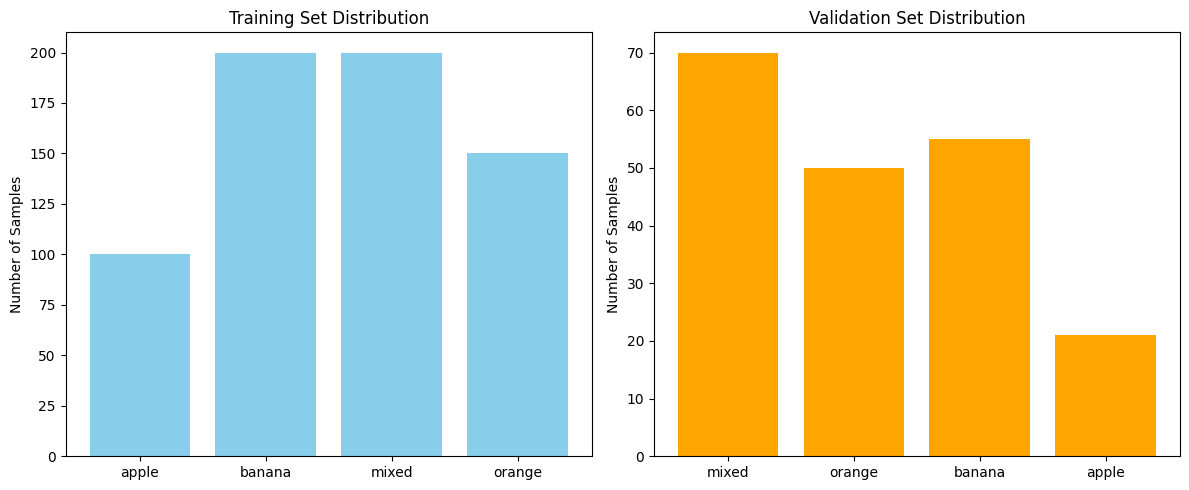

In [39]:
import matplotlib.pyplot as plt

# Count class distribution in training set
train_labels = [train_data.targets[i] for i in final_indices]
train_class_counts = Counter(train_labels)

# Convert class indices to names
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}
train_class_names = [idx_to_class[i] for i in train_class_counts.keys()]
train_counts = list(train_class_counts.values())

# Count class distribution in validation set
val_labels = [train_data.targets[i] for i in val_indices]
val_class_counts = Counter(val_labels)
val_class_names = [idx_to_class[i] for i in val_class_counts.keys()]
val_counts = list(val_class_counts.values())

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(train_class_names, train_counts, color='skyblue')
axs[0].set_title("Training Set Distribution")
axs[0].set_ylabel("Number of Samples")

axs[1].bar(val_class_names, val_counts, color='orange')
axs[1].set_title("Validation Set Distribution")
axs[1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()



### Tuned Run #1:
**Epoch=15 to Epoch=30**


Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 1.2907, Train Acc: 0.3811, Val Loss: 1.1788, Val Acc: 0.4439
Epoch 2, Train Loss: 0.8955, Train Acc: 0.6322, Val Loss: 0.7934, Val Acc: 0.6122
Epoch 3, Train Loss: 0.6968, Train Acc: 0.7203, Val Loss: 0.7550, Val Acc: 0.7245
Epoch 4, Train Loss: 0.6433, Train Acc: 0.7709, Val Loss: 0.5681, Val Acc: 0.8010
Epoch 5, Train Loss: 0.5471, Train Acc: 0.7996, Val Loss: 0.5886, Val Acc: 0.7449
Epoch 6, Train Loss: 0.4178, Train Acc: 0.8326, Val Loss: 0.5306, Val Acc: 0.8112
Epoch 7, Train Loss: 0.3978, Train Acc: 0.8568, Val Loss: 0.6031, Val Acc: 0.7806
Epoch 8, Train Loss: 0.4014, Train Acc: 0.8546, Val Loss: 0.5160, Val Acc: 0.8163
Epoch 9, Train Loss: 0.3872, Train Acc: 0.8634, Val Loss: 0.7798, Val Acc: 0.7347
Epoch 10, Train Loss: 0.3753, Train Acc: 0.8634, Val Loss: 0.5643, Val Acc: 0.7959
Epoch 11, Train Loss: 0.2787, Train Acc: 0.8877, Val Loss: 0.6502, Val Acc: 0.7602
Epoch 12, Train Loss: 0.2135, 

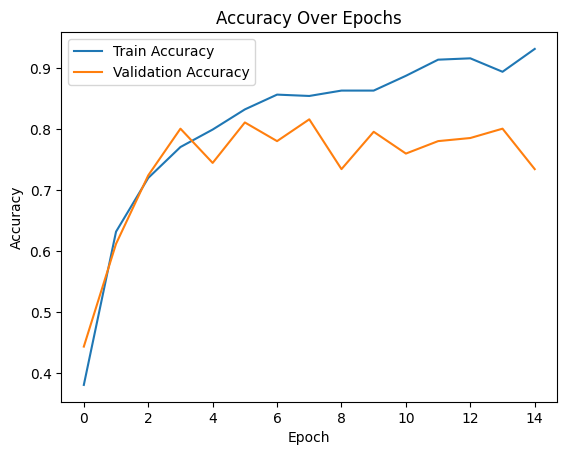

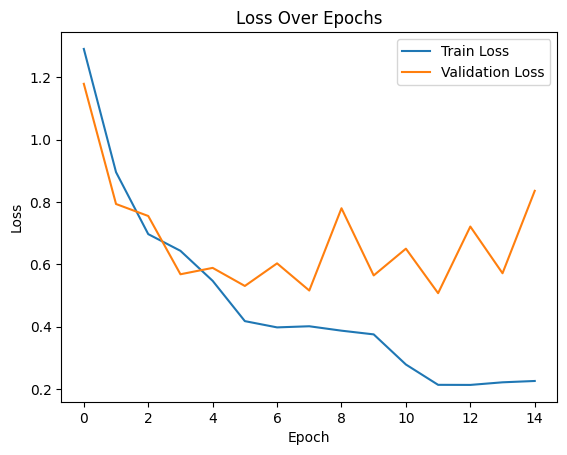

In [55]:
# Import required libraries
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from collections import Counter, defaultdict
import random

# Paths
train_path = "./train"
test_path = "./test"

# Transformations
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

transform_test = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Load datasets
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

# Toggle to run imbalance test
USE_IMBALANCE_TEST = True

if USE_IMBALANCE_TEST:
    # Step 1: Group full dataset by class
    class_indices = defaultdict(list)
    for idx, label in enumerate(train_data.targets):
        class_indices[label].append(idx)

    # Step 2: Get correct class index mapping
    class_name_to_idx = train_data.class_to_idx

    # Step 3: Use actual counts you confirmed
    desired_counts = {
        class_name_to_idx['apple']: 100,
        class_name_to_idx['banana']: 200,
        class_name_to_idx['mixed']: 200,
        class_name_to_idx['orange']: 150
    }

    # Step 4: Sample the desired number from full dataset
    final_indices = []
    for cls_idx, count in desired_counts.items():
        available = len(class_indices[cls_idx])
        if count > available:
            raise ValueError(f"Requested {count} samples for class {cls_idx}, but only {available} available.")
        final_indices.extend(random.sample(class_indices[cls_idx], count))

    # Step 5: Perform 70/30 split AFTER sampling
    train_size = int(0.7 * len(final_indices))
    val_size = len(final_indices) - train_size
    train_indices, val_indices = random_split(final_indices, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    # Step 6: Create datasets
    train_dataset = Subset(train_data, train_indices)
    val_dataset = Subset(train_data, val_indices)

    # Step 7: Compute class weights for sampler
    class_counts = Counter([train_data.targets[i] for i in train_indices])
    total_samples = sum(class_counts.values())
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[train_data.targets[i]] for i in train_indices]
    train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_indices), replacement=True)

    # Step 8: DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
else:
    # Baseline logic (unchanged)
    train_size = int(0.7 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Classes:", train_data.classes)

# CNN definition
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        return self.model(x)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Init model
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tracking
train_acc, train_loss = [], []
val_acc, val_loss = [], []

# Training
epochs = 15
for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc.append(correct / total)
    train_loss.append(running_loss / len(train_loader))  # Normalized train loss

    # Validation
    model.eval()
    val_correct, val_total, val_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_running_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_acc.append(val_correct / val_total)
    val_loss.append(val_running_loss / len(val_loader))  # Normalized val loss

    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
          f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

# Test
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plots
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Tuned Run #2:
**Epoch=30 with Learning Rate Scheduler**


Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, LR: 0.001000, Train Loss: 1.2559, Train Acc: 0.3987, Val Loss: 1.1756, Val Acc: 0.5000
Epoch 2, LR: 0.001000, Train Loss: 0.8192, Train Acc: 0.6872, Val Loss: 0.6618, Val Acc: 0.7398
Epoch 3, LR: 0.001000, Train Loss: 0.5868, Train Acc: 0.8018, Val Loss: 0.6464, Val Acc: 0.7551
Epoch 4, LR: 0.001000, Train Loss: 0.6183, Train Acc: 0.7753, Val Loss: 0.4880, Val Acc: 0.7959
Epoch 5, LR: 0.001000, Train Loss: 0.5493, Train Acc: 0.8392, Val Loss: 0.6026, Val Acc: 0.7602
Epoch 6, LR: 0.001000, Train Loss: 0.5392, Train Acc: 0.8128, Val Loss: 0.6152, Val Acc: 0.7704
Epoch 7, LR: 0.001000, Train Loss: 0.4020, Train Acc: 0.8744, Val Loss: 0.5755, Val Acc: 0.7653
Epoch 8, LR: 0.000100, Train Loss: 0.3703, Train Acc: 0.8546, Val Loss: 0.5361, Val Acc: 0.8061
Epoch 9, LR: 0.000100, Train Loss: 0.3007, Train Acc: 0.8943, Val Loss: 0.4905, Val Acc: 0.8214
Epoch 10, LR: 0.000100, Train Loss: 0.2579, Train Acc: 0.8987, Val Los

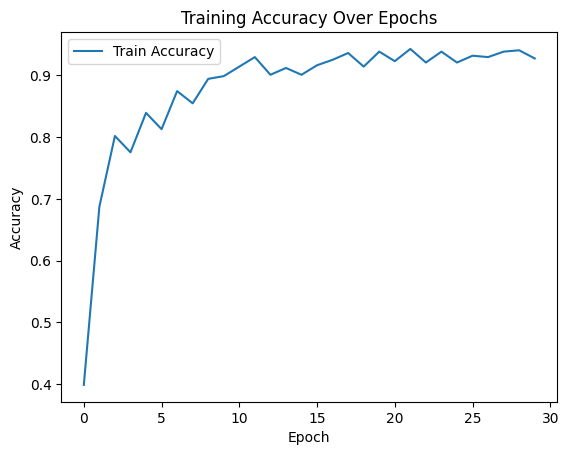

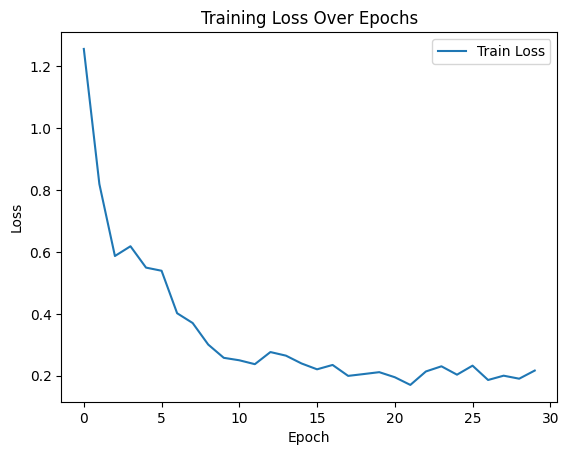

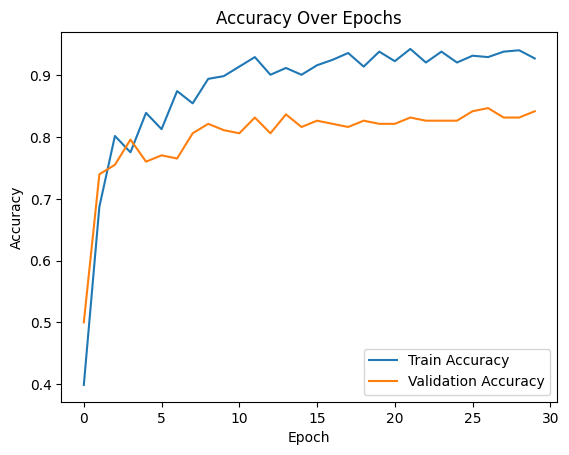

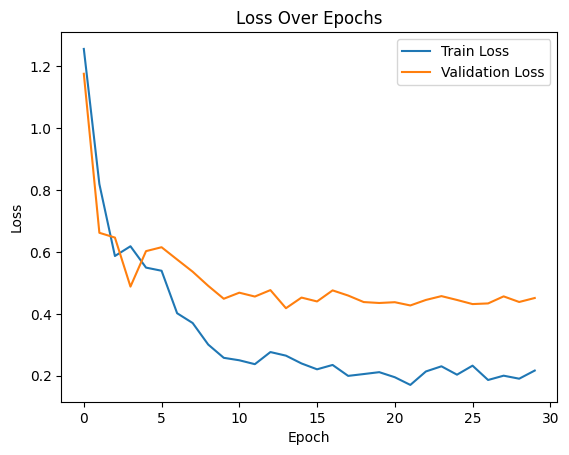

In [45]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define paths to your local training and testing image directories
train_path = "./train"
test_path = "./test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

#Adding in scheduler, once after 3 runs of epoch and it plateau, to start reducing LR by x0.1 with a minimum of 1e-6
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 3, min_lr=1e-6)

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 30

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = correct / total
    train_acc.append(acc)
    train_loss.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct / val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss / len(val_loader))

    scheduler.step(val_running_loss / len(val_loader))

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}, LR: {current_lr:.6f}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Tuned Run #3:
**Epoch=50 with Learning Rate Scheduler**


Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, LR: 0.001000, Train Loss: 1.2980, Train Acc: 0.3877, Val Loss: 1.2364, Val Acc: 0.4847
Epoch 2, LR: 0.001000, Train Loss: 1.0203, Train Acc: 0.5925, Val Loss: 0.8024, Val Acc: 0.6633
Epoch 3, LR: 0.001000, Train Loss: 0.7593, Train Acc: 0.7335, Val Loss: 0.8626, Val Acc: 0.6480
Epoch 4, LR: 0.001000, Train Loss: 0.6843, Train Acc: 0.7225, Val Loss: 0.5853, Val Acc: 0.7806
Epoch 5, LR: 0.001000, Train Loss: 0.5565, Train Acc: 0.7907, Val Loss: 0.6682, Val Acc: 0.7602
Epoch 6, LR: 0.001000, Train Loss: 0.5530, Train Acc: 0.7643, Val Loss: 0.6170, Val Acc: 0.7653
Epoch 7, LR: 0.001000, Train Loss: 0.5357, Train Acc: 0.8040, Val Loss: 0.5710, Val Acc: 0.7959
Epoch 8, LR: 0.001000, Train Loss: 0.3940, Train Acc: 0.8524, Val Loss: 0.5789, Val Acc: 0.8010
Epoch 9, LR: 0.001000, Train Loss: 0.3433, Train Acc: 0.8546, Val Loss: 0.6123, Val Acc: 0.8112
Epoch 10, LR: 0.001000, Train Loss: 0.3572, Train Acc: 0.8678, Val Los

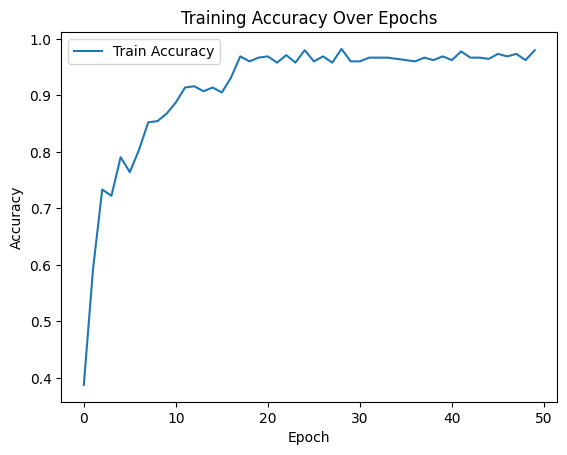

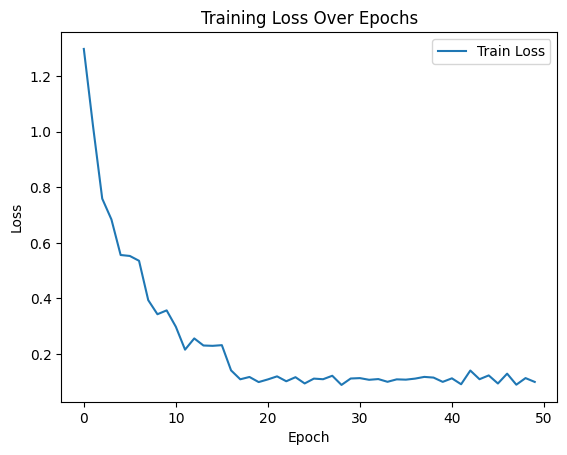

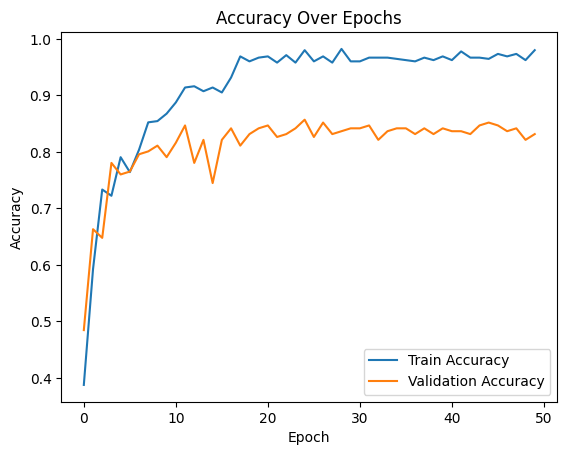

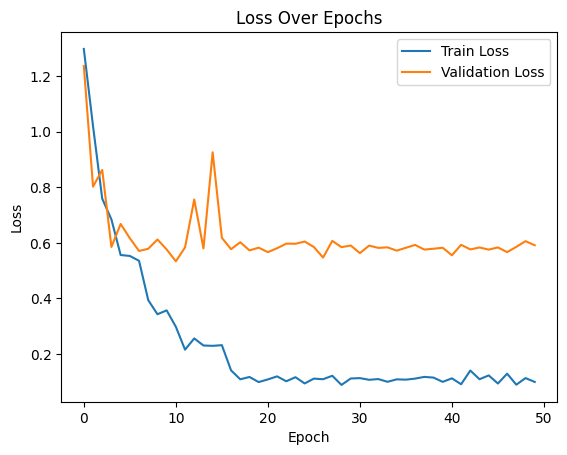

In [46]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define paths to your local training and testing image directories
train_path = "./train"
test_path = "./test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

#Adding in scheduler, once after 3 runs of epoch and it plateau, to start reducing LR by x0.1 with a minimum of 1e-6
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 3, min_lr=1e-6)

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 50

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = correct / total
    train_acc.append(acc)
    train_loss.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_correct += (val_preds == val_labels).sum().item()
            val_total += val_labels.size(0)

    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_acc = val_correct / val_total

    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    scheduler.step(epoch_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}, LR: {current_lr:.6f}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {acc:.4f}, "
        f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")


# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
